# Advanced Keras tutorial

## Siamese network tutorial

Siamese networks could have many definition. We will stick to the one where network has two exactly the same branches which are used for the final computation. In this tutorial we will build a siamese network for adding two numbers - where each number is represented as an image from `sklearn.digits` dataset. Let's start from setting up the data:

In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

dataset = load_digits()

x, y = dataset['data'], dataset['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8)

Each image is represented in form of $(64,)$ vector. Let's have a look at couple of these images:

In [2]:
import matplotlib.pyplot as plt

size_of_square = 5

plt.figure(figsize=(size_of_square * 2, size_of_square * 2))

for image_nb in range(size_of_square ** 2):
    plt.subplot(size_of_square, size_of_square, image_nb + 1)
    plt.axis('off')
    plt.imshow(x_train[image_nb].reshape((8, 8)))
    plt.title(y_train[image_nb])
plt.show()

Let's start with building a _dummy_ solution.

In [3]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, add
from keras.models import Model
from keras.regularizers import l2

L2 = 0.001

# Left Branch
input_to_left_branch = Input(shape=(8, 8, 1))

aux_left_branch = input_to_left_branch

aux_left_branch = Conv2D(
    10, 3,
    activation='relu',
    padding='same',
    kernel_regularizer=l2(L2),
)(aux_left_branch)
aux_left_branch = MaxPooling2D()(aux_left_branch)
aux_left_branch = Conv2D(
    20, 3,
    activation='relu',
    padding='valid',
    kernel_regularizer=l2(L2),
)(aux_left_branch)
aux_left_branch = MaxPooling2D()(aux_left_branch)
aux_left_branch = Flatten()(aux_left_branch)

# Right Branch
input_to_right_branch = Input(shape=(8, 8, 1))

aux_right_branch = input_to_right_branch

aux_right_branch = Conv2D(
    10, 3,
    activation='relu',
    padding='same',
    kernel_regularizer=l2(L2),
)(aux_right_branch)
aux_right_branch = MaxPooling2D()(aux_right_branch)
aux_right_branch = Conv2D(
    20, 3,
    activation='relu',
    padding='valid',
    kernel_regularizer=l2(L2),
)(aux_right_branch)
aux_right_branch = MaxPooling2D()(aux_right_branch)
aux_right_branch = Flatten()(aux_right_branch)

# Merging branches
merged = add([aux_left_branch, aux_right_branch])
output = Dense(1)(merged)

model = Model((input_to_left_branch, input_to_right_branch), output)
left_branch = Model(input_to_left_branch, aux_left_branch)
right_branch = Model(input_to_right_branch, aux_right_branch)

model.compile(optimizer='adam', loss='mse', metrics=['mse'])

model.summary()

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8, 8, 1)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 8, 8, 1)      0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 10)     100         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 8, 8, 10)     100         input_2[0][0]                    
__________________________________________________________________________________________________
max_poolin

**FUNNY QUESTION NR 1:** Why do we use the `mse` both as a loss and as a metric?

We plan to check whether both legs of siamese network learn similar things - let's make a special `Callback` for this:

In [4]:
from keras.callbacks import Callback

class SiameseCallback(Callback):
    def __init__(self, left_model, right_model, data):
        self._left_model = left_model
        self._right_model = right_model
        self._data = data
        self.left_values = None
        self.right_values = None
        
    def on_train_begin(self, logs):
        self.left_values = []
        self.right_values = []
        
    def on_epoch_end(self, epoch, logs):
        self.left_values.append(self._left_model.predict(self._data))
        self.right_values.append(self._right_model.predict(self._data))
        
siamese_callback = SiameseCallback(
    left_model=left_branch,
    right_model=right_branch,
    data=x_train.reshape((-1, 8, 8, 1)) / 255.0,
)

Now let's set up everything for training. We plan to use `fit_generator` method by defining a special generator which will feed tuples to the network:

In [5]:
import numpy


def digits_pairs_generator(
    digits,
    targets,
    batch_size,
):
    nb_of_rows = digits.shape[0]
    while True:
        left_indices = numpy.random.randint(
            low=0,
            high=digits.shape[0],
            size=batch_size,
        )
        right_indices = numpy.random.randint(
            low=0,
            high=digits.shape[0],
            size=batch_size,
        )
        left_array = digits[left_indices].reshape((-1, 8, 8, 1)) / 255.0
        right_array = digits[right_indices].reshape((-1, 8, 8, 1)) / 255.0
        values = (targets[left_indices] + targets[right_indices]).astype('float32')
        values -= 9.0
        values /= 2.9        
        yield [left_array, right_array], values

Now - let's feed the model:

In [6]:
history = model.fit_generator(
    digits_pairs_generator(x_train, y_train, 128),
    steps_per_epoch=500,
    epochs=100,
    callbacks=[siamese_callback]
)

Epoch 1/100
500/500 [==============================] - 4s 9ms/step - loss: 1.4102 - mean_squared_error: 1.3599
Epoch 2/100
500/500 [==============================] - 5s 9ms/step - loss: 0.6643 - mean_squared_error: 0.5573
Epoch 3/100
500/500 [==============================] - 4s 9ms/step - loss: 0.5483 - mean_squared_error: 0.4308
Epoch 4/100
500/500 [==============================] - 5s 9ms/step - loss: 0.5070 - mean_squared_error: 0.3878
Epoch 5/100
500/500 [==============================] - 4s 8ms/step - loss: 0.4721 - mean_squared_error: 0.3524
Epoch 6/100
500/500 [==============================] - 4s 8ms/step - loss: 0.4519 - mean_squared_error: 0.3322
Epoch 7/100
500/500 [==============================] - 4s 8ms/step - loss: 0.4304 - mean_squared_error: 0.3104
Epoch 8/100
500/500 [==============================] - 4s 8ms/step - loss: 0.4190 - mean_squared_error: 0.2987
Epoch 9/100
500/500 [==============================] - 4s 8ms/step - loss: 0.4010 - mean_squared_error: 0.2806
E

500/500 [==============================] - 4s 8ms/step - loss: 0.1822 - mean_squared_error: 0.0874
Epoch 75/100
500/500 [==============================] - 4s 8ms/step - loss: 0.1799 - mean_squared_error: 0.0855
Epoch 76/100
500/500 [==============================] - 4s 8ms/step - loss: 0.1804 - mean_squared_error: 0.0864
Epoch 77/100
500/500 [==============================] - 4s 8ms/step - loss: 0.1795 - mean_squared_error: 0.0858
Epoch 78/100
500/500 [==============================] - 4s 8ms/step - loss: 0.1794 - mean_squared_error: 0.0860
Epoch 79/100
500/500 [==============================] - 4s 8ms/step - loss: 0.1774 - mean_squared_error: 0.0843
Epoch 80/100
500/500 [==============================] - 4s 7ms/step - loss: 0.1771 - mean_squared_error: 0.0842
Epoch 81/100
500/500 [==============================] - 4s 8ms/step - loss: 0.1737 - mean_squared_error: 0.0812
Epoch 82/100
500/500 [==============================] - 4s 8ms/step - loss: 0.1756 - mean_squared_error: 0.0835
Epoch

In `keras` method `fit` returns something different than in classic `sklearn` API. It returns a special `keras.callbacks.History` callback object which stores a dictionary with all metrics computed after each epochs:

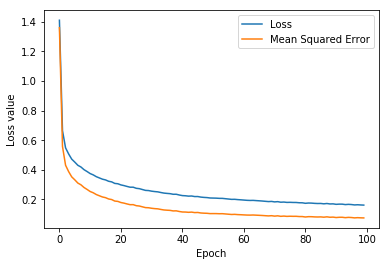

In [7]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['mean_squared_error'], label='Mean Squared Error')
plt.legend()
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.show()

**ANSWER TO FUNNY QUESTION NR 1** - As you may see - loss is not only `mse` but also other regularization terms.

Now - let's have a look at how it works on a _test set_.

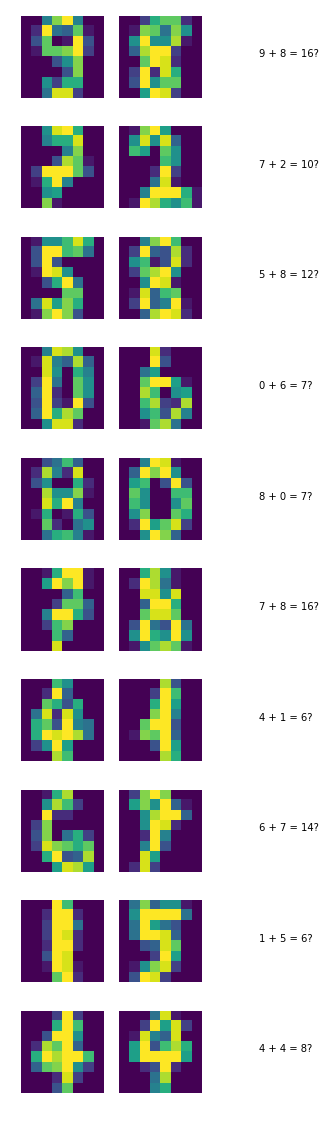

In [8]:
examples = 10

plt.figure(figsize=(examples * 0.5, 20))
for i in range(examples):
    plt.subplot(examples, 3, 3 * i + 1)
    plt.axis('off')
    left_image = x_test[3 * i].reshape((8, 8))
    plt.imshow(left_image)
    plt.subplot(examples, 3, 3 * i + 2)
    plt.axis('off')
    right_image = x_test[3 * i + 1].reshape((8, 8))
    plt.imshow(right_image)
    plt.subplot(examples, 3, 3 * i + 3)
    plt.axis('off')
    plt.text(0.5, 0.5, '%d + %d = %d?' % (
        y_test[3 * i],
        y_test[3 * i + 1],
        round(model.predict(
        [
            left_image.reshape((1, 8, 8, 1)) / 255.0,
            right_image.reshape((1, 8, 8, 1)) / 255.0,
        ])[0, 0] * 2.9 + 9)))

**Funny question nr 2:** Is left branch the same as a right one? Should they be the same? 

Well - let's have a look:

In [9]:
left_values = numpy.array(siamese_callback.left_values)
right_values = numpy.array(siamese_callback.right_values)

In [10]:
def compute_siamese_activations_cosine(left_values_, right_values_):
    dot_product = (left_values_ * right_values_).sum(axis=-1)
    left_norm = (left_values_ ** 2).sum(axis=-1) ** 0.5
    right_norm = (right_values_ ** 2).sum(axis=-1) ** 0.5
    return dot_product / (left_norm * right_norm)

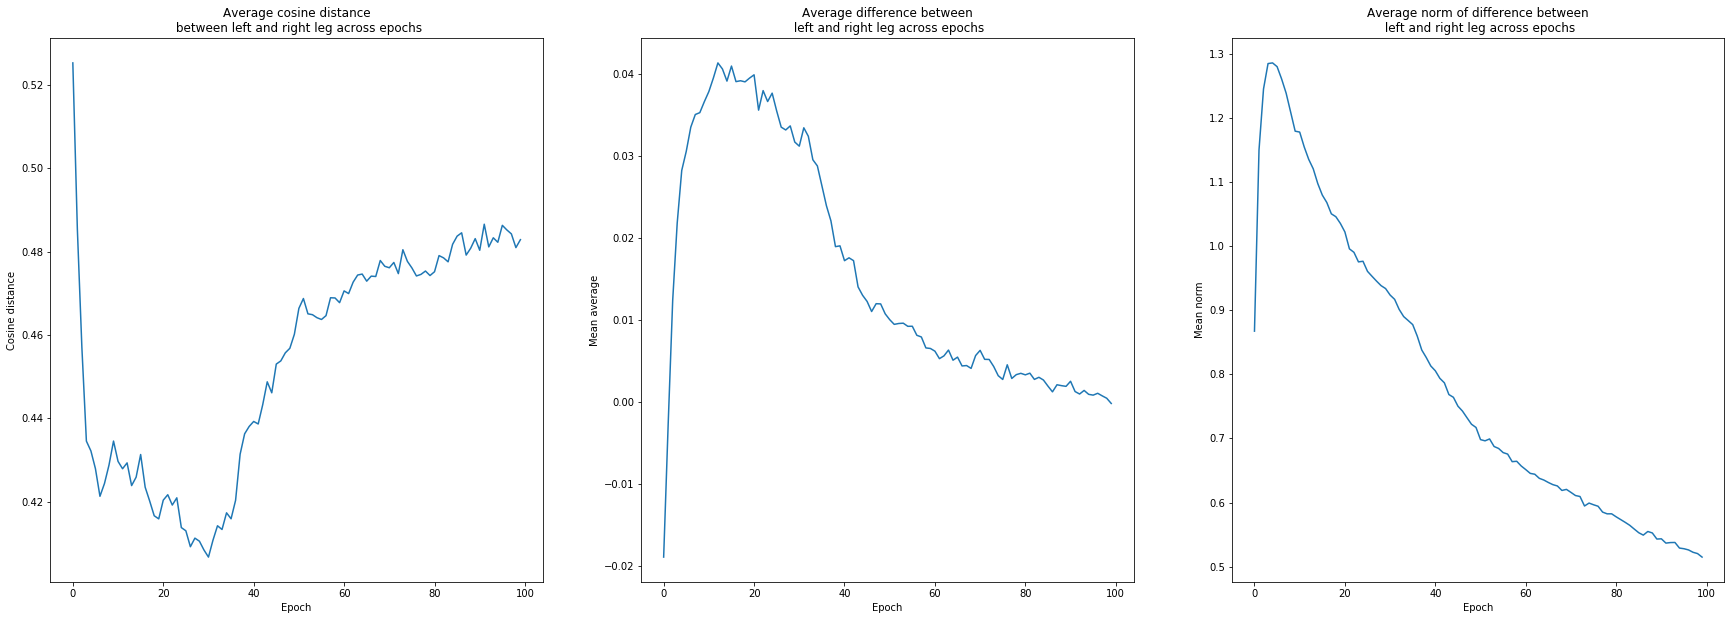

In [11]:
plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
plt.title('Average cosine distance\n between left and right leg across epochs')
plt.xlabel('Epoch')
plt.ylabel('Cosine distance')
plt.plot(compute_siamese_activations_cosine(left_values, right_values).mean(axis=-1))
plt.subplot(1, 3, 2)
plt.title('Average difference between\n left and right leg across epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean average')
plt.plot((left_values - right_values).mean(axis=(1, 2)))
plt.subplot(1, 3, 3)
plt.title('Average norm of difference between\n left and right leg across epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean norm')
plt.plot((((left_values - right_values) ** 2).sum(axis=-1) ** 0.5).mean(axis=-1))
plt.show()

**ANSWER TO THE FUNNY QUESTION NR 2:** They are not, but they are slowly learn to be the same.

So - how can we make them to be the same from the start? Well - thanks to `keras.layers` special properties we can do that:

In [12]:
from keras.layers import Layer

class SiameseBranch(Layer):
    def __init__(
        self,
        first_layer_size=10,
        first_layer_filter_size=3,
        second_layer_size=20,
        second_layer_filter_size=3,
        activation='relu',
        padding='same',
        l2_rate=L2,
    ):
        self.first_conv = Conv2D(
            first_layer_size,
            first_layer_filter_size,
            activation=activation,
            padding=padding,
            kernel_regularizer=l2(l2_rate),
        )
        self.first_pooling = MaxPooling2D()
        self.second_conv = Conv2D(
            second_layer_size,
            second_layer_filter_size,
            activation=activation,
            padding=padding,
            kernel_regularizer=l2(l2_rate),
        )
        self.second_pooling = aux_left_branch = MaxPooling2D()
        self.flatten = Flatten()
        
    def __call__(self, input_tensor):
        return self.flatten(
            self.second_pooling(
                self.second_conv(
                    self.first_pooling(
                        self.first_conv(input_tensor)
                    )
                )
            )
        )

Now - let's define a model using it:

In [13]:
new_input_to_left_branch = Input(shape=(8, 8, 1))

siamese_branch = SiameseBranch()

new_aux_left_branch = siamese_branch(
    input_tensor=new_input_to_left_branch,
)

# Right Branch
new_input_to_right_branch = Input(shape=(8, 8, 1))

new_aux_right_branch = siamese_branch(
    input_tensor=new_input_to_right_branch)

# Merging branches
new_merged = add([new_aux_left_branch, new_aux_right_branch])
new_output = Dense(1)(new_merged)

new_model = Model(
    (new_input_to_left_branch, new_input_to_right_branch),
    new_output)
new_left_branch = Model(new_input_to_left_branch, new_aux_left_branch)
new_right_branch = Model(new_input_to_right_branch, new_aux_right_branch)

new_model.compile(optimizer='adam', loss='mse', metrics=['mse'])

new_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 8, 8, 1)      0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 8, 8, 1)      0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 8, 8, 10)     100         input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 4, 4, 10)     0           conv2d_5[0][0]                   
          

As you may see - there is way less tensors now. Now 's fit a model:

In [14]:
new_siamese_callback = SiameseCallback(
    left_model=new_left_branch,
    right_model=new_right_branch,
    data=x_train.reshape((-1, 8, 8, 1)) / 255.0,
)

new_history = new_model.fit_generator(
    digits_pairs_generator(x_train, y_train, 128),
    steps_per_epoch=500,
    epochs=100,
    callbacks=[new_siamese_callback]
)

Epoch 1/100
500/500 [==============================] - 6s 11ms/step - loss: 1.1281 - mean_squared_error: 1.0865
Epoch 2/100
500/500 [==============================] - 6s 11ms/step - loss: 0.5436 - mean_squared_error: 0.4693
Epoch 3/100
500/500 [==============================] - 6s 11ms/step - loss: 0.4152 - mean_squared_error: 0.3325
Epoch 4/100
500/500 [==============================] - 5s 10ms/step - loss: 0.3594 - mean_squared_error: 0.2747
Epoch 5/100
500/500 [==============================] - 5s 10ms/step - loss: 0.3319 - mean_squared_error: 0.2459
Epoch 6/100
500/500 [==============================] - 5s 10ms/step - loss: 0.3035 - mean_squared_error: 0.2165
Epoch 7/100
500/500 [==============================] - 5s 10ms/step - loss: 0.2852 - mean_squared_error: 0.1977
Epoch 8/100
500/500 [==============================] - 5s 10ms/step - loss: 0.2648 - mean_squared_error: 0.1770
Epoch 9/100
500/500 [==============================] - 5s 10ms/step - loss: 0.2569 - mean_squared_error:

500/500 [==============================] - 5s 10ms/step - loss: 0.0989 - mean_squared_error: 0.0384
Epoch 74/100
500/500 [==============================] - 5s 10ms/step - loss: 0.0969 - mean_squared_error: 0.0368
Epoch 75/100
500/500 [==============================] - 5s 10ms/step - loss: 0.0981 - mean_squared_error: 0.0382
Epoch 76/100
500/500 [==============================] - 5s 10ms/step - loss: 0.0977 - mean_squared_error: 0.0380
Epoch 77/100
500/500 [==============================] - 5s 11ms/step - loss: 0.0949 - mean_squared_error: 0.0356
Epoch 78/100
500/500 [==============================] - 5s 11ms/step - loss: 0.0956 - mean_squared_error: 0.0365
Epoch 79/100
500/500 [==============================] - 5s 10ms/step - loss: 0.0946 - mean_squared_error: 0.0358
Epoch 80/100
500/500 [==============================] - 5s 10ms/step - loss: 0.0943 - mean_squared_error: 0.0359
Epoch 81/100
500/500 [==============================] - 6s 11ms/step - loss: 0.0933 - mean_squared_error: 0.0

Now - let's have a look at metrics across epochs - can you spot the difference?

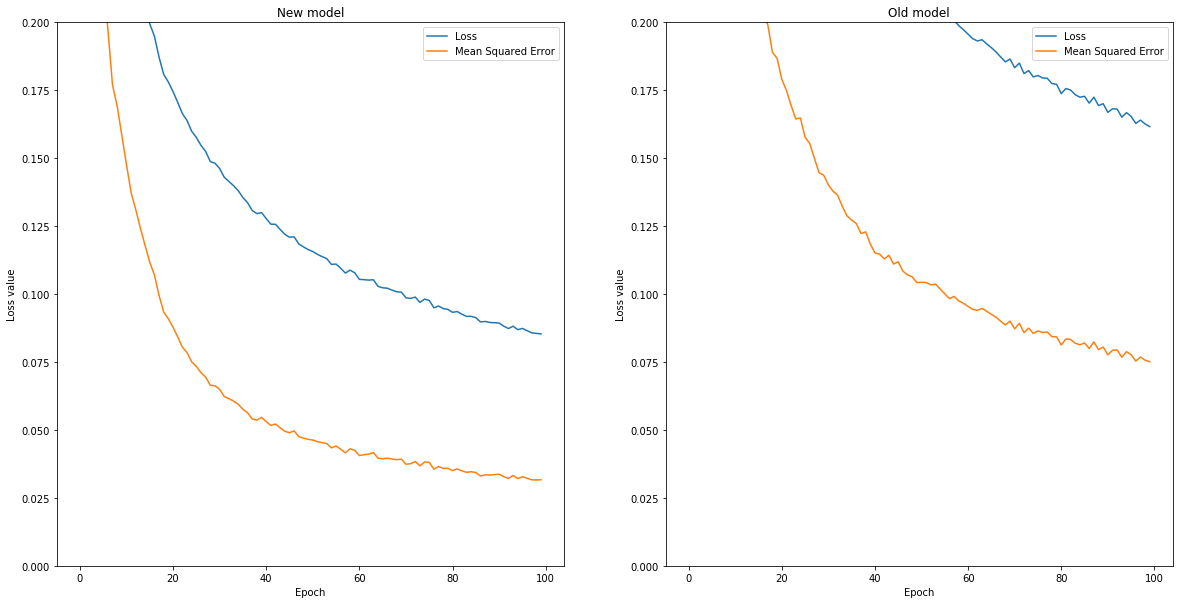

In [15]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title('New model')
plt.plot(new_history.history['loss'], label='Loss')
plt.plot(new_history.history['mean_squared_error'], label='Mean Squared Error')
plt.legend()
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.ylim([0.0, 0.2])
plt.subplot(1, 2, 2)
plt.title('Old model')
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['mean_squared_error'], label='Mean Squared Error')
plt.legend()
plt.ylabel('Loss value')
plt.xlabel('Epoch')
plt.ylim([0.0, 0.2])
plt.show()

How about results on the test set?

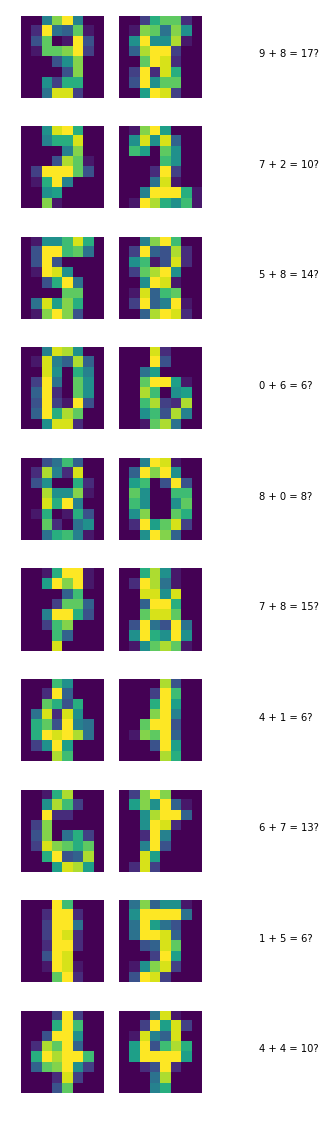

In [16]:
examples = 10

plt.figure(figsize=(examples * 0.5, 20))
for i in range(examples):
    plt.subplot(examples, 3, 3 * i + 1)
    plt.axis('off')
    left_image = x_test[3 * i].reshape((8, 8))
    plt.imshow(left_image)
    plt.subplot(examples, 3, 3 * i + 2)
    plt.axis('off')
    right_image = x_test[3 * i + 1].reshape((8, 8))
    plt.imshow(right_image)
    plt.subplot(examples, 3, 3 * i + 3)
    plt.axis('off')
    plt.text(0.5, 0.5, '%d + %d = %d?' % (
        y_test[3 * i],
        y_test[3 * i + 1],
        round(new_model.predict(
        [
            left_image.reshape((1, 8, 8, 1)) / 255.0,
            right_image.reshape((1, 8, 8, 1)) / 255.0,
        ])[0, 0] * 2.9 + 9)))

So - how the differences between left and right branches activations should now look like?

In [17]:
new_left_values = numpy.array(new_siamese_callback.left_values)
new_right_values = numpy.array(new_siamese_callback.right_values)

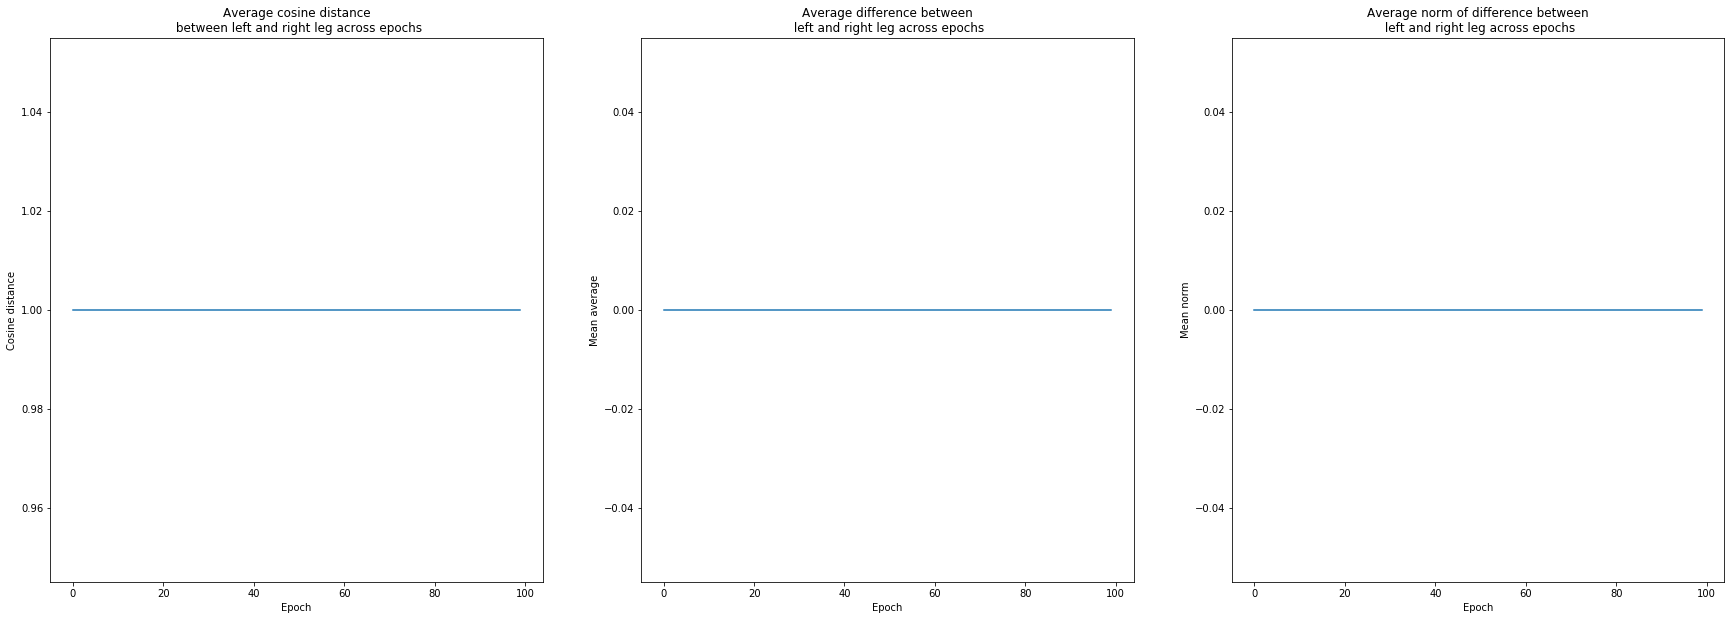

In [18]:
plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
plt.title('Average cosine distance\n between left and right leg across epochs')
plt.xlabel('Epoch')
plt.ylabel('Cosine distance')
plt.plot(compute_siamese_activations_cosine(new_left_values, new_right_values).mean(axis=-1))
plt.subplot(1, 3, 2)
plt.title('Average difference between\n left and right leg across epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean average')
plt.plot((new_left_values - new_right_values).mean(axis=(1, 2)))
plt.subplot(1, 3, 3)
plt.title('Average norm of difference between\n left and right leg across epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean norm')
plt.plot((((new_left_values - new_right_values) ** 2).sum(axis=-1) ** 0.5).mean(axis=-1))
plt.show()

Well - **Sometimes it takes quite a long time for a neural network to learn obvious things.**

## Let's play with Backend by implementing the Channel Inhibited Softmax

`keras` simplicity is one of it's main advantages. But it's also a disadvantage when one wants to implement a not obvious network. Here is where `keras.backend` shines.

So - what is a **Channel Inhibited Softmax**? It's a new activation layer with additional output to a `softmax` activation which is always $0$. Thanks to this we could measure the so-called _epistemic_ error of our network. Let's try to implement it:

In [19]:
from keras import backend as K

def channel_inhibited_softmax(input_to_layer):
    additional_zeros_channel = K.zeros_like(input_to_layer[:, 0])
    additional_zeros_channel = K.expand_dims(additional_zeros_channel)
    concatenated_input_to_softmax = K.concatenate(
        [input_to_layer, additional_zeros_channel], axis=-1)
    return K.softmax(concatenated_input_to_softmax, axis=-1)

Now - let's use it for classifing whether a number is equal to $0$ or $5$. We will use a branch pretrained on previous task:

In [20]:
input_to_classification = Input(shape=(8, 8, 1))

aux_output_to_classification = siamese_branch(input_to_classification)

classification_output = Dense(
    units=2,
    activation=channel_inhibited_softmax,
)(aux_output_to_classification)

classification_model = Model(input_to_classification, classification_output)

classification_model.compile(
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', 'sparse_categorical_crossentropy'],
    optimizer='adam',
)

Now - let's prepare a dataset for training:

In [21]:
y_train_classification_list = [target for target in y_train if target in [0, 5]]
y_train_classification = numpy.array(y_train_classification_list) == 5
x_train_classification = x_train[[target in [0, 5] for target in y_train]]

y_test_classification_list = [target for target in y_test if target in [0, 5]]
y_test_classification = numpy.array(y_test_classification_list) == 5
x_test_classification = x_test[[target in [0, 5] for target in y_test]]

And finally - let's fit the model:

In [22]:
classification_history = classification_model.fit(
    x=x_train_classification.reshape((-1, 8, 8, 1)) / 255.0,
    y=y_train_classification,
    validation_split=0.2,
    epochs=500,
    batch_size=128,
)

Train on 229 samples, validate on 58 samples
Epoch 1/500
229/229 [==============================] - 0s 1ms/step - loss: 1.1176 - acc: 0.5197 - sparse_categorical_crossentropy: 1.0640 - val_loss: 1.1091 - val_acc: 0.4655 - val_sparse_categorical_crossentropy: 1.0556
Epoch 2/500
229/229 [==============================] - 0s 66us/step - loss: 1.0900 - acc: 0.5197 - sparse_categorical_crossentropy: 1.0365 - val_loss: 1.0827 - val_acc: 0.4655 - val_sparse_categorical_crossentropy: 1.0292
Epoch 3/500
229/229 [==============================] - 0s 62us/step - loss: 1.0637 - acc: 0.5197 - sparse_categorical_crossentropy: 1.0102 - val_loss: 1.0586 - val_acc: 0.4655 - val_sparse_categorical_crossentropy: 1.0051
Epoch 4/500
229/229 [==============================] - 0s 82us/step - loss: 1.0393 - acc: 0.5197 - sparse_categorical_crossentropy: 0.9858 - val_loss: 1.0365 - val_acc: 0.4655 - val_sparse_categorical_crossentropy: 0.9831
Epoch 5/500
229/229 [==============================] - 0s 86us/step 

229/229 [==============================] - 0s 122us/step - loss: 0.4948 - acc: 0.9956 - sparse_categorical_crossentropy: 0.4348 - val_loss: 0.5053 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.4450
Epoch 38/500
229/229 [==============================] - 0s 91us/step - loss: 0.4832 - acc: 0.9956 - sparse_categorical_crossentropy: 0.4229 - val_loss: 0.4936 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.4330
Epoch 39/500
229/229 [==============================] - 0s 90us/step - loss: 0.4721 - acc: 0.9956 - sparse_categorical_crossentropy: 0.4113 - val_loss: 0.4818 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.4208
Epoch 40/500
229/229 [==============================] - 0s 103us/step - loss: 0.4611 - acc: 0.9956 - sparse_categorical_crossentropy: 0.3999 - val_loss: 0.4711 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.4097
Epoch 41/500
229/229 [==============================] - 0s 76us/step - loss: 0.4501 - acc: 0.9956 - sparse_categorical_

Epoch 74/500
229/229 [==============================] - 0s 86us/step - loss: 0.2172 - acc: 0.9956 - sparse_categorical_crossentropy: 0.1433 - val_loss: 0.2256 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.1515
Epoch 75/500
229/229 [==============================] - 0s 75us/step - loss: 0.2134 - acc: 0.9956 - sparse_categorical_crossentropy: 0.1393 - val_loss: 0.2214 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.1470
Epoch 76/500
229/229 [==============================] - 0s 87us/step - loss: 0.2097 - acc: 0.9956 - sparse_categorical_crossentropy: 0.1352 - val_loss: 0.2180 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.1433
Epoch 77/500
229/229 [==============================] - 0s 89us/step - loss: 0.2062 - acc: 0.9956 - sparse_categorical_crossentropy: 0.1314 - val_loss: 0.2144 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.1394
Epoch 78/500
229/229 [==============================] - 0s 98us/step - loss: 0.2028 - acc: 0.9956 - sparse_c

Epoch 111/500
229/229 [==============================] - 0s 88us/step - loss: 0.1413 - acc: 0.9956 - sparse_categorical_crossentropy: 0.0605 - val_loss: 0.1417 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0608
Epoch 112/500
229/229 [==============================] - 0s 84us/step - loss: 0.1404 - acc: 0.9956 - sparse_categorical_crossentropy: 0.0594 - val_loss: 0.1409 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0599
Epoch 113/500
229/229 [==============================] - 0s 78us/step - loss: 0.1395 - acc: 0.9956 - sparse_categorical_crossentropy: 0.0585 - val_loss: 0.1398 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0587
Epoch 114/500
229/229 [==============================] - 0s 67us/step - loss: 0.1386 - acc: 0.9956 - sparse_categorical_crossentropy: 0.0575 - val_loss: 0.1388 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0577
Epoch 115/500
229/229 [==============================] - 0s 72us/step - loss: 0.1376 - acc: 0.9956 - spa

229/229 [==============================] - 0s 85us/step - loss: 0.1184 - acc: 0.9956 - sparse_categorical_crossentropy: 0.0369 - val_loss: 0.1165 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0350
Epoch 148/500
229/229 [==============================] - 0s 78us/step - loss: 0.1180 - acc: 0.9956 - sparse_categorical_crossentropy: 0.0365 - val_loss: 0.1160 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0345
Epoch 149/500
229/229 [==============================] - 0s 77us/step - loss: 0.1176 - acc: 0.9956 - sparse_categorical_crossentropy: 0.0361 - val_loss: 0.1153 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0338
Epoch 150/500
229/229 [==============================] - 0s 73us/step - loss: 0.1172 - acc: 0.9956 - sparse_categorical_crossentropy: 0.0357 - val_loss: 0.1148 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0333
Epoch 151/500
229/229 [==============================] - 0s 75us/step - loss: 0.1168 - acc: 0.9956 - sparse_categorica

Epoch 184/500
229/229 [==============================] - 0s 75us/step - loss: 0.1059 - acc: 0.9956 - sparse_categorical_crossentropy: 0.0265 - val_loss: 0.1031 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0238
Epoch 185/500
229/229 [==============================] - 0s 76us/step - loss: 0.1056 - acc: 0.9956 - sparse_categorical_crossentropy: 0.0263 - val_loss: 0.1026 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0234
Epoch 186/500
229/229 [==============================] - 0s 97us/step - loss: 0.1054 - acc: 0.9956 - sparse_categorical_crossentropy: 0.0262 - val_loss: 0.1022 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0231
Epoch 187/500
229/229 [==============================] - 0s 107us/step - loss: 0.1051 - acc: 0.9956 - sparse_categorical_crossentropy: 0.0260 - val_loss: 0.1020 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0229
Epoch 188/500
229/229 [==============================] - 0s 80us/step - loss: 0.1048 - acc: 0.9956 - sp

229/229 [==============================] - 0s 71us/step - loss: 0.0972 - acc: 0.9956 - sparse_categorical_crossentropy: 0.0212 - val_loss: 0.0947 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0188
Epoch 221/500
229/229 [==============================] - 0s 67us/step - loss: 0.0969 - acc: 1.0000 - sparse_categorical_crossentropy: 0.0211 - val_loss: 0.0944 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0186
Epoch 222/500
229/229 [==============================] - 0s 72us/step - loss: 0.0967 - acc: 1.0000 - sparse_categorical_crossentropy: 0.0209 - val_loss: 0.0941 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0184
Epoch 223/500
229/229 [==============================] - 0s 83us/step - loss: 0.0965 - acc: 1.0000 - sparse_categorical_crossentropy: 0.0208 - val_loss: 0.0940 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0183
Epoch 224/500
229/229 [==============================] - 0s 74us/step - loss: 0.0963 - acc: 1.0000 - sparse_categorica

229/229 [==============================] - 0s 69us/step - loss: 0.0902 - acc: 1.0000 - sparse_categorical_crossentropy: 0.0181 - val_loss: 0.0878 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0158
Epoch 257/500
229/229 [==============================] - 0s 76us/step - loss: 0.0900 - acc: 1.0000 - sparse_categorical_crossentropy: 0.0180 - val_loss: 0.0874 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0155
Epoch 258/500
229/229 [==============================] - 0s 82us/step - loss: 0.0898 - acc: 1.0000 - sparse_categorical_crossentropy: 0.0179 - val_loss: 0.0872 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0154
Epoch 259/500
229/229 [==============================] - 0s 83us/step - loss: 0.0896 - acc: 1.0000 - sparse_categorical_crossentropy: 0.0178 - val_loss: 0.0870 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0153
Epoch 260/500
229/229 [==============================] - 0s 71us/step - loss: 0.0895 - acc: 1.0000 - sparse_categorica

229/229 [==============================] - 0s 102us/step - loss: 0.0841 - acc: 1.0000 - sparse_categorical_crossentropy: 0.0160 - val_loss: 0.0819 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0138
Epoch 293/500
229/229 [==============================] - 0s 72us/step - loss: 0.0840 - acc: 1.0000 - sparse_categorical_crossentropy: 0.0159 - val_loss: 0.0818 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0138
Epoch 294/500
229/229 [==============================] - 0s 73us/step - loss: 0.0839 - acc: 1.0000 - sparse_categorical_crossentropy: 0.0159 - val_loss: 0.0817 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0138
Epoch 295/500
229/229 [==============================] - 0s 68us/step - loss: 0.0837 - acc: 1.0000 - sparse_categorical_crossentropy: 0.0158 - val_loss: 0.0815 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0137
Epoch 296/500
229/229 [==============================] - 0s 76us/step - loss: 0.0835 - acc: 1.0000 - sparse_categoric

Epoch 329/500
229/229 [==============================] - 0s 72us/step - loss: 0.0788 - acc: 1.0000 - sparse_categorical_crossentropy: 0.0145 - val_loss: 0.0774 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0132
Epoch 330/500
229/229 [==============================] - 0s 71us/step - loss: 0.0786 - acc: 1.0000 - sparse_categorical_crossentropy: 0.0144 - val_loss: 0.0770 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0129
Epoch 331/500
229/229 [==============================] - 0s 81us/step - loss: 0.0784 - acc: 1.0000 - sparse_categorical_crossentropy: 0.0144 - val_loss: 0.0767 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0128
Epoch 332/500
229/229 [==============================] - 0s 96us/step - loss: 0.0783 - acc: 1.0000 - sparse_categorical_crossentropy: 0.0143 - val_loss: 0.0765 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0126
Epoch 333/500
229/229 [==============================] - 0s 85us/step - loss: 0.0782 - acc: 1.0000 - spa

229/229 [==============================] - 0s 76us/step - loss: 0.0740 - acc: 1.0000 - sparse_categorical_crossentropy: 0.0133 - val_loss: 0.0727 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0121
Epoch 366/500
229/229 [==============================] - 0s 85us/step - loss: 0.0739 - acc: 1.0000 - sparse_categorical_crossentropy: 0.0133 - val_loss: 0.0726 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0121
Epoch 367/500
229/229 [==============================] - 0s 84us/step - loss: 0.0738 - acc: 1.0000 - sparse_categorical_crossentropy: 0.0133 - val_loss: 0.0726 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0122
Epoch 368/500
229/229 [==============================] - 0s 124us/step - loss: 0.0737 - acc: 1.0000 - sparse_categorical_crossentropy: 0.0133 - val_loss: 0.0723 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0120
Epoch 369/500
229/229 [==============================] - 0s 108us/step - loss: 0.0735 - acc: 1.0000 - sparse_categori

Epoch 402/500
229/229 [==============================] - 0s 75us/step - loss: 0.0697 - acc: 1.0000 - sparse_categorical_crossentropy: 0.0125 - val_loss: 0.0686 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0114
Epoch 403/500
229/229 [==============================] - 0s 72us/step - loss: 0.0696 - acc: 1.0000 - sparse_categorical_crossentropy: 0.0125 - val_loss: 0.0685 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0114
Epoch 404/500
229/229 [==============================] - 0s 71us/step - loss: 0.0695 - acc: 1.0000 - sparse_categorical_crossentropy: 0.0124 - val_loss: 0.0685 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0115
Epoch 405/500
229/229 [==============================] - 0s 70us/step - loss: 0.0694 - acc: 1.0000 - sparse_categorical_crossentropy: 0.0125 - val_loss: 0.0685 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0116
Epoch 406/500
229/229 [==============================] - 0s 73us/step - loss: 0.0693 - acc: 1.0000 - spa

229/229 [==============================] - 0s 94us/step - loss: 0.0660 - acc: 1.0000 - sparse_categorical_crossentropy: 0.0119 - val_loss: 0.0650 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0109
Epoch 439/500
229/229 [==============================] - 0s 80us/step - loss: 0.0660 - acc: 1.0000 - sparse_categorical_crossentropy: 0.0119 - val_loss: 0.0650 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0110
Epoch 440/500
229/229 [==============================] - 0s 70us/step - loss: 0.0659 - acc: 1.0000 - sparse_categorical_crossentropy: 0.0119 - val_loss: 0.0650 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0111
Epoch 441/500
229/229 [==============================] - 0s 89us/step - loss: 0.0657 - acc: 1.0000 - sparse_categorical_crossentropy: 0.0118 - val_loss: 0.0648 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0110
Epoch 442/500
229/229 [==============================] - 0s 79us/step - loss: 0.0657 - acc: 1.0000 - sparse_categorica

Epoch 475/500
229/229 [==============================] - 0s 81us/step - loss: 0.0627 - acc: 1.0000 - sparse_categorical_crossentropy: 0.0113 - val_loss: 0.0620 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0107
Epoch 476/500
229/229 [==============================] - 0s 69us/step - loss: 0.0626 - acc: 1.0000 - sparse_categorical_crossentropy: 0.0113 - val_loss: 0.0623 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0111
Epoch 477/500
229/229 [==============================] - 0s 64us/step - loss: 0.0626 - acc: 1.0000 - sparse_categorical_crossentropy: 0.0114 - val_loss: 0.0625 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0113
Epoch 478/500
229/229 [==============================] - 0s 80us/step - loss: 0.0625 - acc: 1.0000 - sparse_categorical_crossentropy: 0.0113 - val_loss: 0.0622 - val_acc: 1.0000 - val_sparse_categorical_crossentropy: 0.0111
Epoch 479/500
229/229 [==============================] - 0s 73us/step - loss: 0.0625 - acc: 1.0000 - spa

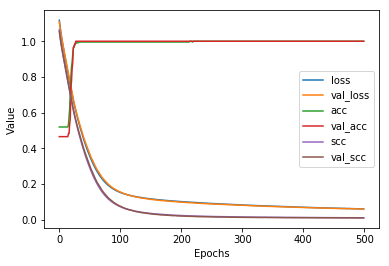

In [23]:
plt.plot(classification_history.history['loss'], label='loss')
plt.plot(classification_history.history['val_loss'], label='val_loss')
plt.plot(classification_history.history['acc'], label='acc')
plt.plot(classification_history.history['val_acc'], label='val_acc')
plt.plot(classification_history.history['sparse_categorical_crossentropy'], label='scc')
plt.plot(classification_history.history['val_sparse_categorical_crossentropy'], label='val_scc')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.show()

Now - let's analyze the scores:

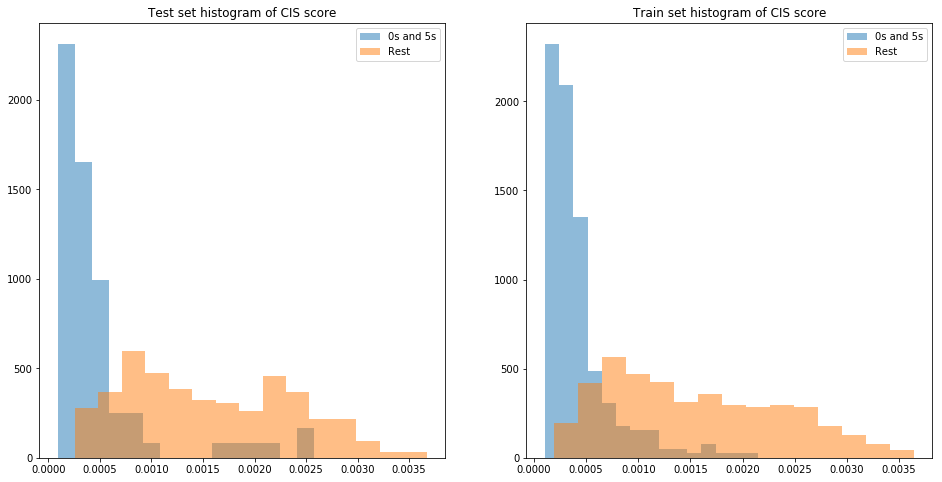

In [24]:
predictions = classification_model.predict(
    x=x_test.reshape((-1, 8, 8, 1)) / 255.0,
)

train_predictions = classification_model.predict(
    x=x_train.reshape((-1, 8, 8, 1)) / 255.0,
)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.title('Test set histogram of CIS score')
plt.hist(
    predictions[:, 2][[target in [0, 5] for target in y_test]],
    bins=15,
    normed=True,
    alpha=0.5,
    label='0s and 5s',
)
plt.hist(
    predictions[:, 2][[target not in [0, 5] for target in y_test]], 
    bins=15,
    normed=True,
    label='Rest',
    alpha=0.5,
)
plt.legend()
plt.subplot(1, 2, 2)
plt.title('Train set histogram of CIS score')
plt.hist(
    train_predictions[:, 2][[target in [0, 5] for target in y_train]],
    bins=15,
    normed=True,
    alpha=0.5,
    label='0s and 5s',
)
plt.hist(
    train_predictions[:, 2][[target not in [0, 5] for target in y_train]], 
    bins=15,
    normed=True,
    label='Rest',
    alpha=0.5,
)
plt.legend()
plt.show()

Now - let's have a look at how different classes are represented

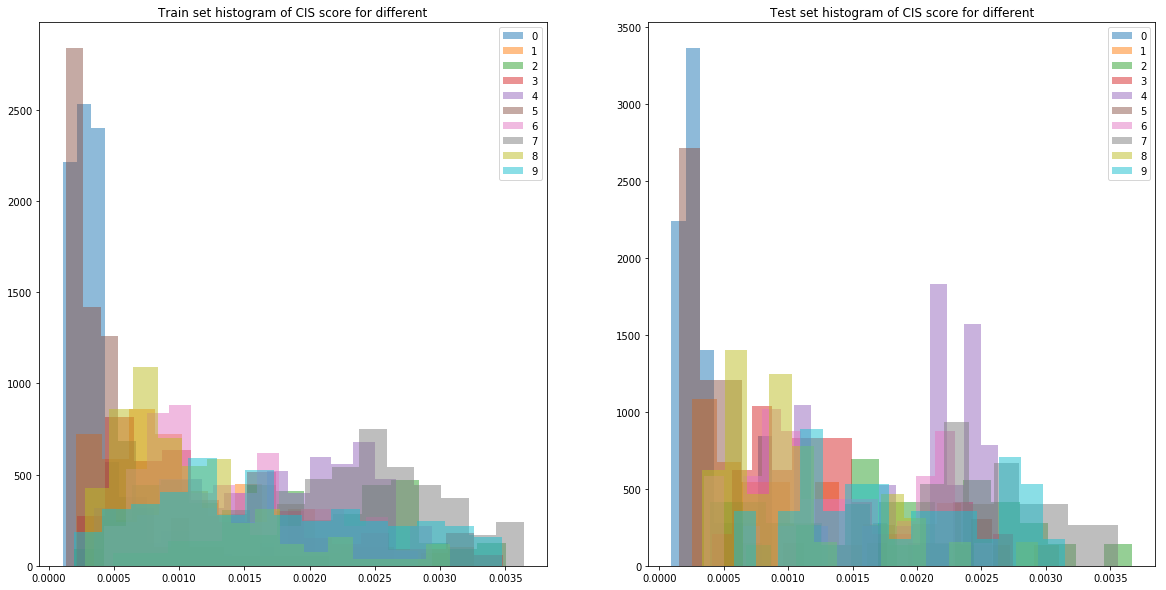

In [41]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
for number in range(10):
    plt.title('Train set histogram of CIS score for different')
    plt.hist(
        train_predictions[:, 2][y_train == number],
        bins=15,
        normed=True,
        alpha=0.5,
        label=str(number),
    )
plt.legend()
plt.subplot(1, 2, 2)
for number in range(10):
    plt.title('Test set histogram of CIS score for different')
    plt.hist(
        predictions[:, 2][y_test == number],
        bins=15,
        normed=True,
        alpha=0.5,
        label=str(number),
    )
plt.legend()
plt.show()

As one may see - the _epistemic_ error is correctly measured by the last channel of **CIS**. 

## Let's continue to play with Backend by implementing the variational dropout

Variational dropout is a really interesting technique which could improve your classifiers and help you to measure the uncertainty of your model. In the following example we will show how to implement a simple `Variational Dropout` model in `keras` and show a toy example of a technique used e.g. by **UBER**:

Let's start with getting the dummy dataset for classification:

In [25]:
points = [(-2, -2), (-2, 2), (2, 2), (2, -2)]
sigmas = [0.1, 0.2, 0.1, 0.2]
sigma_matrices = [numpy.eye(2) * sigma for sigma in sigmas]
number_of_points = 1000

datasets = [
    numpy.random.multivariate_normal(
        point,
        sigma,
        size=(number_of_points)) for point, sigma in zip(points, sigma_matrices)]
dataset = numpy.concatenate(datasets)
targets = []
for point in points:
    targets += [point] * number_of_points
targets = numpy.array(targets)

Now, let's have a look at how this dataset looks like:

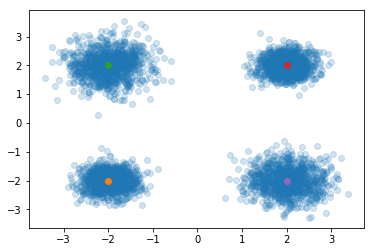

In [26]:
plt.scatter(dataset[:, 0], dataset[:, 1], alpha=0.2)
for point in points:
    plt.scatter(point[0], point[1])
plt.show()

Now - let's build a simple model for predictions:

In [27]:
from keras.layers import Dropout

input_to_vd = Input(shape=(2,))

aux_vd = input_to_vd

aux_vd = Dense(30, activation='tanh', kernel_regularizer=l2(L2))(aux_vd)
aux_vd = Dropout(0.5)(aux_vd)
output_vd = Dense(2)(aux_vd)

vd_model = Model(input_to_vd, output_vd)
vd_model.compile(loss='mse', optimizer='sgd', metrics=['mse'])
vd_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 30)                90        
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 62        
Total params: 152
Trainable params: 152
Non-trainable params: 0
_________________________________________________________________


And fit it:

In [28]:
vd_history = vd_model.fit(
    x=targets,
    y=dataset,
    epochs=200,
    batch_size=128,
    validation_split=0.2,
)

Train on 3200 samples, validate on 800 samples
Epoch 1/200
3200/3200 [==============================] - 0s 78us/step - loss: 2.0240 - mean_squared_error: 2.0216 - val_loss: 0.6933 - val_mean_squared_error: 0.6908
Epoch 2/200
3200/3200 [==============================] - 0s 10us/step - loss: 0.7070 - mean_squared_error: 0.7045 - val_loss: 0.3646 - val_mean_squared_error: 0.3622
Epoch 3/200
3200/3200 [==============================] - 0s 10us/step - loss: 0.6153 - mean_squared_error: 0.6129 - val_loss: 0.3036 - val_mean_squared_error: 0.3013
Epoch 4/200
3200/3200 [==============================] - 0s 10us/step - loss: 0.5815 - mean_squared_error: 0.5792 - val_loss: 0.2646 - val_mean_squared_error: 0.2623
Epoch 5/200
3200/3200 [==============================] - 0s 11us/step - loss: 0.5303 - mean_squared_error: 0.5280 - val_loss: 0.2539 - val_mean_squared_error: 0.2517
Epoch 6/200
3200/3200 [==============================] - 0s 11us/step - loss: 0.5102 - mean_squared_error: 0.5080 - val_los

Epoch 50/200
3200/3200 [==============================] - 0s 16us/step - loss: 0.3675 - mean_squared_error: 0.3655 - val_loss: 0.2362 - val_mean_squared_error: 0.2342
Epoch 51/200
3200/3200 [==============================] - 0s 14us/step - loss: 0.3672 - mean_squared_error: 0.3652 - val_loss: 0.2459 - val_mean_squared_error: 0.2439
Epoch 52/200
3200/3200 [==============================] - 0s 15us/step - loss: 0.3749 - mean_squared_error: 0.3728 - val_loss: 0.2439 - val_mean_squared_error: 0.2418
Epoch 53/200
3200/3200 [==============================] - 0s 17us/step - loss: 0.3757 - mean_squared_error: 0.3737 - val_loss: 0.2426 - val_mean_squared_error: 0.2406
Epoch 54/200
3200/3200 [==============================] - 0s 15us/step - loss: 0.3854 - mean_squared_error: 0.3833 - val_loss: 0.2336 - val_mean_squared_error: 0.2315
Epoch 55/200
3200/3200 [==============================] - 0s 16us/step - loss: 0.3748 - mean_squared_error: 0.3727 - val_loss: 0.2358 - val_mean_squared_error: 0.233

3200/3200 [==============================] - 0s 10us/step - loss: 0.3695 - mean_squared_error: 0.3676 - val_loss: 0.2454 - val_mean_squared_error: 0.2435
Epoch 100/200
3200/3200 [==============================] - 0s 10us/step - loss: 0.3760 - mean_squared_error: 0.3740 - val_loss: 0.2568 - val_mean_squared_error: 0.2549
Epoch 101/200
3200/3200 [==============================] - 0s 10us/step - loss: 0.3677 - mean_squared_error: 0.3658 - val_loss: 0.2487 - val_mean_squared_error: 0.2468
Epoch 102/200
3200/3200 [==============================] - 0s 10us/step - loss: 0.3604 - mean_squared_error: 0.3584 - val_loss: 0.2563 - val_mean_squared_error: 0.2544
Epoch 103/200
3200/3200 [==============================] - 0s 11us/step - loss: 0.3671 - mean_squared_error: 0.3652 - val_loss: 0.2500 - val_mean_squared_error: 0.2481
Epoch 104/200
3200/3200 [==============================] - 0s 11us/step - loss: 0.3487 - mean_squared_error: 0.3468 - val_loss: 0.2580 - val_mean_squared_error: 0.2561
Epoch 

Epoch 148/200
3200/3200 [==============================] - 0s 11us/step - loss: 0.3678 - mean_squared_error: 0.3659 - val_loss: 0.2552 - val_mean_squared_error: 0.2534
Epoch 149/200
3200/3200 [==============================] - 0s 11us/step - loss: 0.3648 - mean_squared_error: 0.3630 - val_loss: 0.2618 - val_mean_squared_error: 0.2599
Epoch 150/200
3200/3200 [==============================] - 0s 11us/step - loss: 0.3651 - mean_squared_error: 0.3633 - val_loss: 0.2645 - val_mean_squared_error: 0.2627
Epoch 151/200
3200/3200 [==============================] - 0s 10us/step - loss: 0.3653 - mean_squared_error: 0.3635 - val_loss: 0.2651 - val_mean_squared_error: 0.2633
Epoch 152/200
3200/3200 [==============================] - 0s 10us/step - loss: 0.3776 - mean_squared_error: 0.3758 - val_loss: 0.2578 - val_mean_squared_error: 0.2560
Epoch 153/200
3200/3200 [==============================] - 0s 11us/step - loss: 0.3654 - mean_squared_error: 0.3636 - val_loss: 0.2552 - val_mean_squared_error:

Epoch 197/200
3200/3200 [==============================] - 0s 13us/step - loss: 0.3790 - mean_squared_error: 0.3773 - val_loss: 0.2508 - val_mean_squared_error: 0.2491
Epoch 198/200
3200/3200 [==============================] - 0s 11us/step - loss: 0.3745 - mean_squared_error: 0.3728 - val_loss: 0.2522 - val_mean_squared_error: 0.2505
Epoch 199/200
3200/3200 [==============================] - 0s 11us/step - loss: 0.3688 - mean_squared_error: 0.3670 - val_loss: 0.2539 - val_mean_squared_error: 0.2521
Epoch 200/200
3200/3200 [==============================] - 0s 12us/step - loss: 0.3639 - mean_squared_error: 0.3621 - val_loss: 0.2575 - val_mean_squared_error: 0.2558


As one may see we have a slight overfit:

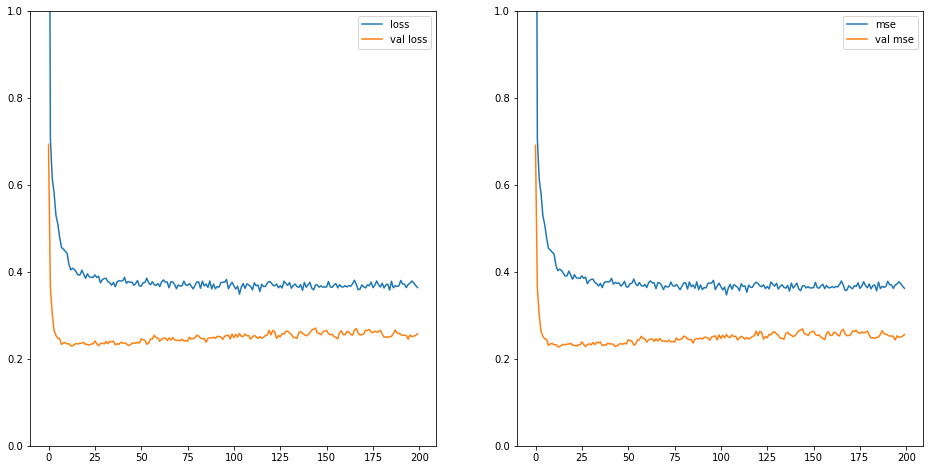

In [29]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(vd_history.history['loss'], label='loss')
plt.plot(vd_history.history['val_loss'], label='val loss')
plt.ylim([0.0, 1.0])
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(vd_history.history['mean_squared_error'], label='mse')
plt.plot(vd_history.history['val_mean_squared_error'], label='val mse')
plt.ylim([0.0, 1.0])
plt.legend()
plt.show()

Now - let's have a look at predictions:

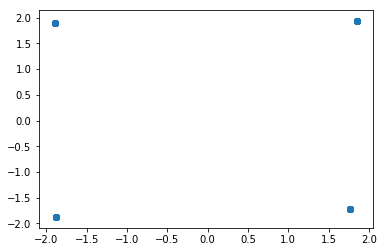

In [30]:
vd_predictions = vd_model.predict(targets)

plt.scatter(vd_predictions[:, 0], vd_predictions[:, 1])
plt.show()

But - can we recover the uncertainty straight from the model? Let's try use a _Variational Dropout_ technique to it. Let's start from defining something interesting: `keras.function`.

In [31]:
keras_model_function = K.function([vd_model.input], [vd_model.output])

keras_model_function([dataset])

[array([[-1.623883 , -2.4219046],
        [-2.1566088, -1.6680555],
        [-1.8740023, -1.8235366],
        ...,
        [ 2.0622277, -1.0288806],
        [ 1.8002719, -1.92991  ],
        [ 1.1278192, -2.263157 ]], dtype=float32)]

Ok - but let's go even further, let's add additional tensor `K.learning_phase()` to inputs to our function:

In [32]:
vd_keras_model_function = K.function([vd_model.input, K.learning_phase()], [vd_model.output])

number_of_tries = 100

different_predictions_list = [vd_keras_model_function([targets, 1])
                              for _ in range(number_of_tries)]
different_predictions = numpy.array(different_predictions_list).reshape(
    (-1, dataset.shape[0], dataset.shape[1]),
)
print(different_predictions.shape)

(100, 4000, 2)


Now - due to the `Dropout` layer and `learning_phase` set to `1` - we have new _variational dropout_ predictions:

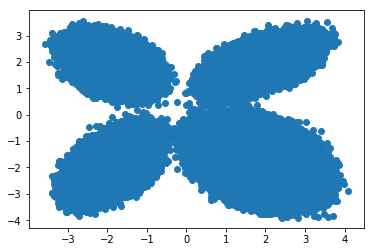

In [33]:
vd_predictions_for_scatter = numpy.concatenate(
    [different_predictions[prediction_nb] for prediction_nb in range(number_of_tries)]
)
plt.scatter(vd_predictions_for_scatter[:, 0], vd_predictions_for_scatter[:, 1])
plt.show()

And now - let's analyze correlations:

In [34]:
correlations = [numpy.cov(different_predictions[:, i, :].transpose()) for i in range(dataset.shape[0])]

for i in range(4):
    print(
        numpy.array(
            correlations[i * number_of_points: (i + 1) * number_of_points]).mean(axis=(0))
    )

[[0.16785846 0.10455979]
 [0.10455979 0.26002672]]
[[ 0.18494949 -0.07281026]
 [-0.07281026  0.17693825]]
[[0.26394192 0.11516881]
 [0.11516881 0.16695222]]
[[ 0.36594042 -0.13461043]
 [-0.13461043  0.37491066]]


.